In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from pathlib import Path
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [3]:
dataPath = Path('data') / "ecommerce_data.csv"
print("dataPath:", dataPath)

data = pd.read_csv(dataPath, encoding="ISO-8859-1")
data.head()

dataPath: data\ecommerce_data.csv


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


### Impute missing values

In [6]:
data[data["CustomerID"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [7]:
data[data["Description"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


In [8]:
data.CustomerID.value_counts()

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
15070.0       1
15753.0       1
17065.0       1
16881.0       1
16995.0       1
Name: CustomerID, Length: 4372, dtype: int64

In [9]:
# impute missing values for CustomerID
print("data.CustomerID.isnull().sum():", data.CustomerID.isnull().sum())
mostFreqCustomerID = data["CustomerID"].value_counts().index[0]
data['CustomerID'] = data['CustomerID'].fillna(mostFreqCustomerID)
print("data.CustomerID.isnull().sum():", data.CustomerID.isnull().sum())

data.CustomerID.isnull().sum(): 135080
data.CustomerID.isnull().sum(): 0


In [10]:
# impute missing values for Description
print("data.Description.isnull().sum():", data.Description.isnull().sum())
data['Description'] = data['Description'].fillna('Unknown')
print("data.Description.isnull().sum():", data.Description.isnull().sum())

data.Description.isnull().sum(): 1454
data.Description.isnull().sum(): 0


In [11]:
data.CustomerID.value_counts()

17841.0    143063
14911.0      5903
14096.0      5128
12748.0      4642
14606.0      2782
            ...  
15070.0         1
15753.0         1
17065.0         1
16881.0         1
16995.0         1
Name: CustomerID, Length: 4372, dtype: int64

#### Type conversion

In [12]:
# convert CustomerID to int
data['CustomerID'] = data['CustomerID'].astype(int)

In [13]:
# convert InvoiceDate to datetime from string
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


#### Preprocessing

In [14]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [15]:
# create a new column for total amount spent
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [16]:
# This is a buisness decision, we are only interested in customers who have spent money
data = data[data["Quantity"] > 0]
data = data[data["TotalPrice"] > 0]
data.count()

InvoiceNo      530104
StockCode      530104
Description    530104
Quantity       530104
InvoiceDate    530104
UnitPrice      530104
CustomerID     530104
Country        530104
TotalPrice     530104
dtype: int64

In [17]:
data.InvoiceDate.min(), data.InvoiceDate.max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [18]:
# create today date to calculate recency for RFM analysis
today = data.InvoiceDate.max() + pd.DateOffset(days=1)

# RFM analysis

### Create RFM Table

In [19]:
# Recency 
recency = data.groupby("CustomerID").InvoiceDate.max().reset_index()
recency.columns = ["CustomerID", "LastPurchaseDate"]
recency["Recency"] = (today - recency["LastPurchaseDate"]).dt.days
recency.head()


,CustomerID,LastPurchaseDate,Recency
0,12346,2011-01-18 10:01:00,326
1,12347,2011-12-07 15:52:00,2
2,12348,2011-09-25 13:13:00,75
3,12349,2011-11-21 09:51:00,19
4,12350,2011-02-02 16:01:00,310


In [20]:
# Frequency
frequency = data.groupby("CustomerID").InvoiceDate.count().reset_index()
frequency.columns = ["CustomerID", "Frequency"]
frequency.head()

,CustomerID,Frequency
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17


In [21]:
# Monetary
monetary = data.groupby("CustomerID").TotalPrice.sum().reset_index()
monetary.columns = ["CustomerID", "Monetary"]
monetary.head()

,CustomerID,Monetary
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [22]:
# merge all three dataframes
rfm = recency.merge(frequency, on="CustomerID")
rfm = rfm.merge(monetary, on="CustomerID")
rfm.set_index("CustomerID", inplace=True)
rfm.head()


,LastPurchaseDate,Recency,Frequency,Monetary
CustomerID,,,,
12346,2011-01-18 10:01:00,326,1,77183.60
12347,2011-12-07 15:52:00,2,182,4310.00
12348,2011-09-25 13:13:00,75,31,1797.24
12349,2011-11-21 09:51:00,19,73,1757.55
12350,2011-02-02 16:01:00,310,17,334.40


In [23]:
# calculate quartiles for recency, frequency and monetary
quantiles = rfm[["Recency", "Frequency", "Monetary"]].quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.2: 13.400000000000091, 0.4: 33.0, 0.6: 72.0, 0.8: 179.0},
 'Frequency': {0.2: 14.0, 0.4: 29.0, 0.6: 58.0, 0.8: 121.0},
 'Monetary': {0.2: 250.19400000000002,
  0.4: 490.0960000000001,
  0.6: 942.276,
  0.8: 2058.426000000001}}

In [24]:
# create a function to calculate RFM score
def RScore(x, p, d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 2
    else:
        return 1

def FMScore(x, p, d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 4
    else:
        return 5

# create RFM segments
rfm["RScore"] = rfm["Recency"].apply(RScore, args=("Recency", quantiles))
rfm["FScore"] = rfm["Frequency"].apply(FMScore, args=("Frequency", quantiles))
rfm["MScore"] = rfm["Monetary"].apply(FMScore, args=("Monetary", quantiles))
rfm.head()



,LastPurchaseDate,Recency,Frequency,Monetary,RScore,FScore,MScore
CustomerID,,,,,,,
12346,2011-01-18 10:01:00,326,1,77183.60,1,1,5
12347,2011-12-07 15:52:00,2,182,4310.00,5,5,5
12348,2011-09-25 13:13:00,75,31,1797.24,2,3,4
12349,2011-11-21 09:51:00,19,73,1757.55,4,4,4
12350,2011-02-02 16:01:00,310,17,334.40,1,2,2


In [25]:
# create RFM score
rfm["RFMScore"] = rfm.RScore.map(str) + rfm.FScore.map(str) + rfm.MScore.map(str)
rfm.head()

,LastPurchaseDate,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore
CustomerID,,,,,,,,
12346,2011-01-18 10:01:00,326,1,77183.60,1,1,5,115
12347,2011-12-07 15:52:00,2,182,4310.00,5,5,5,555
12348,2011-09-25 13:13:00,75,31,1797.24,2,3,4,234
12349,2011-11-21 09:51:00,19,73,1757.55,4,4,4,444
12350,2011-02-02 16:01:00,310,17,334.40,1,2,2,122


In [26]:
# show all columns 
groupbyRFM = rfm.groupby("RFMScore").agg({
    "Recency": ["count", "mean", "min", "max"], 
    "Frequency": ["count", "mean", "min", "max"], 
    "Monetary": ["count", "mean", "min", "max"]
    }).round(1)

groupbyRFM

Recency                  Frequency                     Monetary  \
           count   mean  min  max     count   mean  min     max    count   
RFMScore                                                                   
111          272  278.8  180  374       272    7.0    1      14      272   
112           74  278.4  184  374        74    9.2    1      14       74   
113           21  262.9  184  366        21    5.9    1      13       21   
114           11  266.6  195  372        11    8.6    2      14       11   
115            5  244.2  182  326         5    3.8    1      10        5   
...          ...    ...  ...  ...       ...    ...  ...     ...      ...   
545           68    6.8    1   12        68   96.6   59     121       68   
552            1    7.0    7    7         1  151.0  151     151        1   
553           23    7.6    2   13        23  164.0  123     218       23   
554           69    6.4    1   13        69  233.7  123     547       69   
555          306    5.3    1   13       306  879.3  123  140067      306   

                                      
             mean     min        max  
RFMScore                              
111         139.0     3.8      250.0  
112         328.8   251.2      489.6  
113         692.9   516.4      931.5  
114        1450.2   944.1     2002.4  
115       33708.5  3096.0    77183.6  
...           ...     ...        ...  
545        5284.2  2069.8    58510.5  
552         452.2   452.2      452.2  
553         767.2   493.3      933.6  
554        1508.1   954.4     2056.9  
555       17423.1  2079.0  1796268.2  

[119 rows x 12 columns]

C:\Users\batuhan\AppData\Local\Temp\ipykernel_9368\3888268258.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


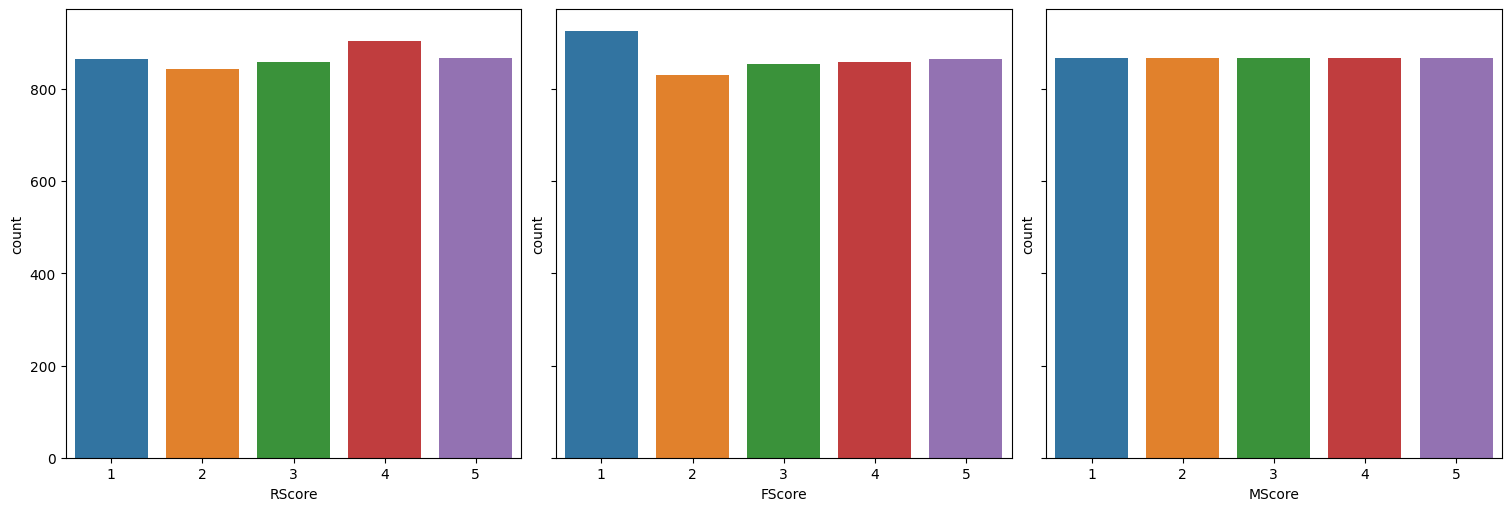

In [27]:
fig, ax =plt.subplots(1,3, figsize=(15,5), sharey=True, sharex=True, constrained_layout=True)
sns.countplot(x="RScore", data=rfm, ax=ax[0])
sns.countplot(x="FScore", data=rfm, ax=ax[1])
sns.countplot(x="MScore", data=rfm, ax=ax[2])
fig.show()

# K-means clustering

C:\Users\batuhan\AppData\Local\Temp\ipykernel_9368\692928323.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm["Recency"], ax=ax[0])
C:\Users\batuhan\AppData\Local\Temp\ipykernel_9368\692928323.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm["Frequency"], ax=ax[1])
C:\Users\batuhan

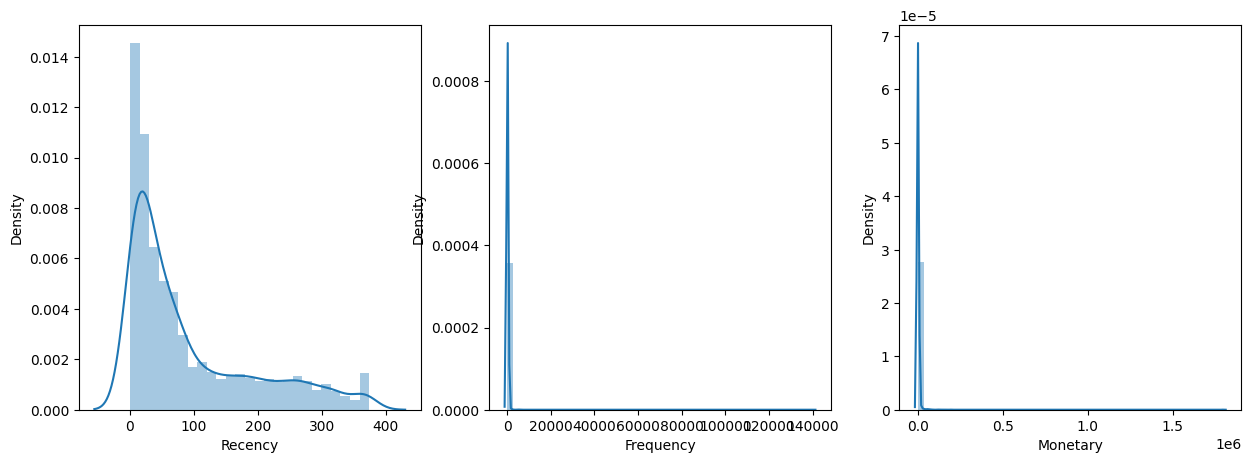

In [28]:
# plot Frequency distribution
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.distplot(rfm["Recency"], ax=ax[0])
sns.distplot(rfm["Frequency"], ax=ax[1])
sns.distplot(rfm["Monetary"], ax=ax[2])
fig.show()


In [29]:
# get outliers for monetary
Q1 = rfm["Monetary"].quantile(0.25)
Q3 = rfm["Monetary"].quantile(0.75)
IQR = Q3 - Q1
outliers = rfm[(rfm["Monetary"] < (Q1 - 1.5 * IQR)) | (rfm["Monetary"] > (Q3 + 1.5 * IQR))]
outliers


,LastPurchaseDate,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore
CustomerID,,,,,,,,
12346,2011-01-18 10:01:00,326,1,77183.60,1,1,5,115
12347,2011-12-07 15:52:00,2,182,4310.00,5,5,5,555
12357,2011-11-06 16:07:00,33,131,6207.67,4,5,5,455
12359,2011-10-13 12:47:00,58,248,6372.58,3,5,5,355
12362,2011-12-06 15:40:00,3,266,5226.23,5,5,5,555
...,...,...,...,...,...,...,...,...
18223,2011-12-05 09:11:00,5,272,6484.54,5,5,5,555
18225,2011-12-06 13:27:00,3,271,5509.12,5,5,5,555
18226,2011-10-26 13:36:00,44,242,5228.05,3,5,5,355


In [30]:
clusterData = rfm[["Recency", "Frequency", "Monetary"]]
clusterData.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


In [39]:
clusterData

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40
...,...,...,...
18280,278,10,180.60
18281,181,7,80.82
18282,8,12,178.05


In [31]:
# normalize the data
scaler = MinMaxScaler()
clusterDataScaled = scaler.fit_transform(clusterData)
clusterDataScaled = pd.DataFrame(clusterDataScaled, index=clusterData.index, columns=clusterData.columns)
clusterDataScaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,0.871314,0.000000,0.042967
12347,0.002681,0.001292,0.002397
12348,0.198391,0.000214,0.000998
12349,0.048257,0.000514,0.000976
12350,0.828418,0.000114,0.000184


In [32]:
clusterDataScaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4338.0,0.245405,0.268135,0.0,0.045576,0.134048,0.378016,1.0
Frequency,4338.0,0.000865,0.015238,0.0,0.000114,0.000286,0.000707,1.0
Monetary,4338.0,0.001367,0.015967,0.0,0.000169,0.000373,0.000923,1.0


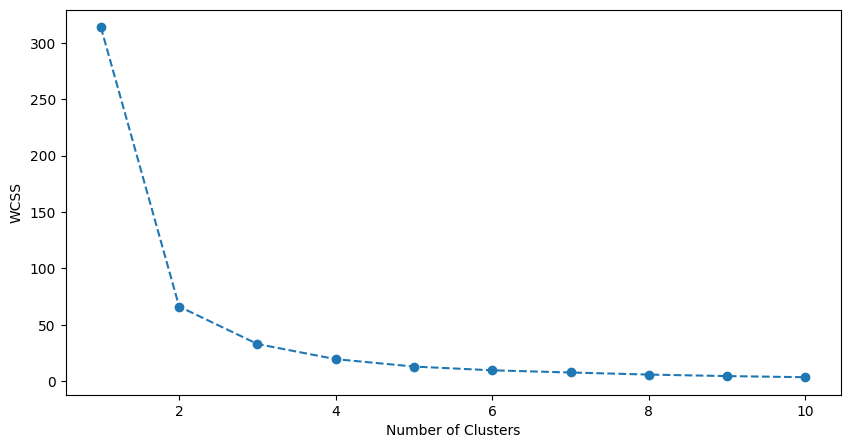

In [33]:
# calculate the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(clusterDataScaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [34]:
# create 4 clusters
kmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300, random_state=42)
kmeans.fit(clusterDataScaled)
pred = kmeans.predict(clusterDataScaled)
pred

array([1, 0, 2, ..., 0, 0, 0])

In [41]:
clusterDataScaled["Cluster"] = kmeans.labels_
clusterData["Cluster"] = kmeans.labels_
clusterDataScaled.head()

C:\Users\batuhan\AppData\Local\Temp\ipykernel_9368\1638629367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusterData["Cluster"] = kmeans.labels_


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,0.871314,0.000000,0.042967,1
12347,0.002681,0.001292,0.002397,0
12348,0.198391,0.000214,0.000998,2
12349,0.048257,0.000514,0.000976,0
12350,0.828418,0.000114,0.000184,1


In [36]:
clusterDataScaled.Cluster.value_counts()

0    2248
2     995
3     598
1     497
Name: Cluster, dtype: int64

In [37]:
clusterDataScaled.groupby("Cluster").mean()

,Recency,Frequency,Monetary
Cluster,,,
0,0.053328,0.001410,0.002214
1,0.825694,0.000162,0.000313
2,0.226826,0.000363,0.000561
3,0.516095,0.000239,0.000399


In [42]:
clusterData.groupby("Cluster").mean()

,Recency,Frequency,Monetary
Cluster,,,
0,20.891459,198.480872,3980.089738
1,308.983903,23.633803,566.710322
2,85.606030,51.835176,1011.566846
3,193.503344,34.443144,721.201958


## Association analysis

# Customer segmentation
